In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch_geometric.data import Batch as gBatch
import glob
import numpy as np
from datasets import *
from sampling_functions import bspline


/home/pietro/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
class SingleTractDataset(gDataset):
    def __init__(self,
                 filename,
                 gt_name=None,
                 same_size=False,
                 transform=None,
                 return_edges=True,
                 split_obj=True,
                 resample=16):
        """
        Args:
            root_dir (string): root directory of the dataset.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.fn = filename
        self.transform = transform
        self.return_edges = return_edges
        self.same_size = same_size
        self.resample = resample
        if split_obj:
            self.remaining = [[]]
        self.split_obj = split_obj
        if gt_name is not None:
            self.labels = [np.load(gt_name)]
            self.with_gt = True
        else:
            self.with_gt = False



    def __len__(self):
        return 1


    def __getitem__(self, idx):
        T_file = self.fn
        T = nib.streamlines.load(T_file, lazy_load=True)
        
        if self.with_gt:
            gt = self.labels[idx]
        if self.split_obj:
            if len(self.remaining[idx]) == 0:
                self.remaining[idx] = set(np.arange(T.header['nb_streamlines']))
            sample = {'points': np.array(list(self.remaining[idx]))}
            if self.with_gt:
                sample['gt'] = gt[list(self.remaining[idx])]
        else:
            sample = {'points': np.arange(T.header['nb_streamlines']), 'gt': gt}

        if self.transform:
            sample = self.transform(sample)

        if self.split_obj:
            self.remaining[idx] -= set(sample['points'])
            sample['obj_idxs'] = sample['points'].copy()
            sample['obj_full_size'] = T.header['nb_streamlines']

        sample['name'] = T_file.split('/')[-1].rsplit('.', 1)[0]

        n = len(sample['points'])
        if self.same_size:
            streams, lengths = load_selected_streamlines_uniform_size(T_file,
                                                    sample['points'].tolist())
            if self.resample:
                streams = self.resample_streamlines(streams.reshape(n,-1,3), 
                                        n_pts=self.resample)
                lengths = np.array([self.resample] * n)
        else:
            streams, lengths = load_selected_streamlines(T_file,
                                                    sample['points'].tolist())
            if self.resample:
                streams = self.resample_streamlines(
                                    np.split(streams, lengths.cumsum()[:-1]), 
                                    n_pts=self.resample)
                lengths = np.array([self.resample] * n)
            
        sample['points'] = self.build_graph_sample(streams,
                    lengths,
                    torch.from_numpy(sample['gt']) if self.with_gt else None)
        return sample

    def resample_streamlines(self, streamlines, type='bspline', n_pts=20):
        resampled = []
        for sl in streamlines:
            if type == 'bspline':
                resampled.append(bspline(sl, n=n_pts))
        return np.concatenate(resampled, axis=0).astype(np.float32)

    def build_graph_sample(self, streams, lengths, gt=None):
        lengths = torch.from_numpy(lengths).long()
        batch_vec = torch.arange(len(lengths)).repeat_interleave(lengths)
        batch_slices = torch.cat([torch.tensor([0]), lengths.cumsum(dim=0)])
        slices = batch_slices[1:-1]
        streams = torch.from_numpy(streams)
        l = streams.shape[0]
        graph_sample = gData(x=streams,
                             lengths=lengths,
                             bvec=batch_vec,
                             pos=streams)

        if self.return_edges:
            e1 = set(np.arange(0,l-1)) - set(slices.numpy()-1)
            e2 = set(np.arange(1,l)) - set(slices.numpy())
            edges = torch.tensor([list(e1)+list(e2),list(e2)+list(e1)],
                            dtype=torch.long)

            graph_sample['edge_index'] = edges
            num_edges = graph_sample.num_edges
            edge_attr = torch.ones(num_edges,1)
            graph_sample['edge_attr'] = edge_attr

        if gt is not None:
            graph_sample['y'] = gt

        return graph_sample


In [3]:
np.random.seed(10)

In [4]:
import configparser

In [5]:
exp = 'runs/sdec_nodropout_loss_nll-data_hcp20_gt20mm_resampled16_fs8000_balanced_sampling_1'

In [6]:
var = 'HCP20'
cfg_parser = configparser.ConfigParser()
cfg_parser.read(exp + '/config.txt')
cfg = {}
cfg[var] = {}
for name, value in cfg_parser.items('DEFAULT'):
    if value == 'y':
        value = True
    elif value == 'n':
        value = False
    cfg[var][name] = value
for name, value in cfg_parser.items(var):
    if value == 'y':
        value = True
    elif value == 'n':
        value = False
    cfg[var][name] = value
cfg = cfg[var]
cfg['weights_path'] = ''
cfg['exp_path'] = exp
cfg['with_gt'] = False

In [86]:
# fn = '/home/pietro/datasets/TractSeg_new/ground_truth_trk/sub-599469/sub-599469_var-GT_AF_left.trk'
# fn = '/home/pietro/datasets/TractSeg_full/downsampled_tractograms/sub-599469/All_500000.trk'
# fn = '/home/pietro/src/tractconverter/599469_AF_left_warped_MNI.trk'
fn = '/home/pietro/src/tractconverter/599469_all_500000_MNI.trk'

In [87]:
dataset = SingleTractDataset(fn,
                            transform=transforms.Compose([TestSampling(int(cfg['fixed_size']))]),
                            return_edges=True,
                            split_obj=True,
                            resample=16)

In [88]:
from train_dsl_cleaned import get_model
from train_dsl_cleaned import get_gbatch_sample

In [10]:
classifier = get_model(cfg)

In [11]:
device = torch.device(0)
torch.cuda.set_device(device)
torch.cuda.current_device()

/home/pietro/.local/lib/python2.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU2 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


0L

In [97]:
if cfg['weights_path'] == '':
    cfg['weights_path'] = glob.glob(cfg['exp_path'] + '/models/best*')[0]
state = torch.load(cfg['weights_path'],map_location=device)

In [98]:
#classifier = get_model(cfg)
classifier.load_state_dict(state)
classifier.cuda()
classifier.eval()


DECSeq(
  (conv1): EdgeConv(nn=Sequential(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  ))
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  ), k=5)
  (lin1): Sequential(
    (0): Sequential(
      (0): Linear(in_features=192, out_features=1024, bias=True

In [89]:
def get_sample(cfg, data):
    points = gBatch().from_data_list([data['points']])
    points = points.to('cuda')
    #points = data['points']
    if 'bvec' in points.keys:
        points.batch = points.bvec.clone()
        del points.bvec
    if cfg['same_size']:
        points['lengths'] = points['lengths'][0].item()
    if cfg['with_gt']:
        target = points['y']
        target = target.to('cuda')
        target = target.view(-1, 1)[:, 0]
        return points, target
    return points

In [100]:
test_preds = []
test_proba = []
with torch.no_grad():
    j = 0
    i=0
    while j < len(dataset):
        consumed = False
        data = dataset[j]
        obj_pred = np.zeros(data['obj_full_size'])
        obj_proba = np.zeros(data['obj_full_size'])
        obj_cls_embedding = np.zeros((data['obj_full_size'],256))
        while not consumed:
            print(i)
            points = get_sample(cfg, data)
            batch = points.batch

            logits = classifier(points)

            pred = F.log_softmax(logits, dim=-1)
            pred_choice = pred.data.max(1)[1].int()

            obj_pred[data['obj_idxs']] = pred_choice.cpu().numpy()
            obj_proba[data['obj_idxs']] = F.softmax(logits, dim=-1)[:,0].cpu().numpy()
            obj_cls_embedding[data['obj_idxs']] = classifier.embedding.cpu().numpy()
            
            print(len(dataset.remaining[j]))

            if len(dataset.remaining[j]) == 0:
                consumed = True
                break
            data = dataset[j]
            i+=1

        j += 1
        test_preds.append(obj_pred)
        test_proba.append(obj_proba)
#         test_confidence.append(np.vstack(obj_conf))

0
492000
1
484000
2
476000
3
468000
4
460000
5
452000
6
444000
7
436000
8
428000
9
420000
10
412000
11
404000
12
396000
13
388000
14
380000
15
372000
16
364000
17
356000
18
348000
19
340000
20
332000
21
324000
22
316000
23
308000
24
300000
25
292000
26
284000
27
276000
28
268000
29
260000
30
252000
31
244000
32
236000
33
228000
34
220000
35
212000
36
204000
37
196000
38
188000
39
180000
40
172000
41
164000
42
156000
43
148000
44
140000
45
132000
46
124000
47
116000
48
108000
49
100000
50
92000
51
84000
52
76000
53
68000
54
60000
55
52000
56
44000
57
36000
58
28000
59
20000
60
12000
61
4000
62
0


In [81]:
torch.tensor(test_proba).squeeze()[idxs_nP].topk(250)[0][-1]

tensor(0.7953, dtype=torch.float64)

In [82]:
idxs_tmp = torch.tensor(test_proba).squeeze()[idxs_nP].topk(250)[1]
idxs_np_topk = idxs_nP[idxs_tmp]

In [43]:
torch.tensor(test_proba).squeeze()[idxs_nP].mean()

tensor(-0.3396, dtype=torch.float64)

In [101]:
idxs_P = np.where(test_preds[0]==1)[0]
idxs_nP = np.where(test_preds[0]==0)[0]

In [102]:
len(idxs_nP)

178131

In [83]:
t_old = nib.streamlines.load(fn)
t_clean = t_old.streamlines[idxs_P]
t_nP = t_old.streamlines[idxs_nP]
t_nP_topk = t_old.streamlines[idxs_np_topk]
# nib.streamlines.save(nib.streamlines.Tractogram(t_clean, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_CC_cleaned.trk', header=t_old.header)
nib.streamlines.save(nib.streamlines.Tractogram(t_nP_topk, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_AF_left_nP_MNI.trk', header=t_old.header)

In [84]:
t_old = nib.streamlines.load('/home/pietro/datasets/TractSeg_new/ground_truth_trk/sub-599469/sub-599469_var-GT_AF_left.trk')
t_clean = t_old.streamlines[idxs_P]
t_nP = t_old.streamlines[idxs_nP]
t_nP_topk = t_old.streamlines[idxs_np_topk]
# nib.streamlines.save(nib.streamlines.Tractogram(t_clean, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_CC_cleaned.trk', header=t_old.header)
nib.streamlines.save(nib.streamlines.Tractogram(t_nP_topk, affine_to_rasmm=np.eye(4)), '/home/pietro/599469_AF_left_nP.trk', header=t_old.header)

In [70]:
# computing length
pdist = nn.PairwiseDistance(p=2)
sl_lengths = []
for sl in t_nP:
    sl =  torch.tensor(sl)
    sl_lengths.append(pdist(sl[:-1], sl[1:]).sum())
sl_lengths = torch.tensor(sl_lengths)

In [71]:
from dipy.tracking.metrics import frenet_serret

In [72]:
sl_curvs = []
for sl in t_nP:
    sl_curvs.append(frenet_serret(sl)[3].mean())
sl_curvs = torch.tensor(sl_curvs)

In [73]:
# different categories length: 0-50 / 50-100 / 100+ ; cruv: 0-0.05 / 0.05-0.1 / 0.1+
len_bins = [sl_lengths<50, (sl_lengths>50) * (sl_lengths<100), sl_lengths>100]
curv_bins = [sl_curvs<0.05, (sl_curvs>0.05) * (sl_curvs<0.1), sl_curvs>0.1]
print(torch.tensor([x.sum() for x in len_bins]).float()/float(len(idxs_nP)))
print(torch.tensor([x.sum() for x in curv_bins]).float()/float(len(idxs_nP)))

tensor([0.0000, 0.0154, 0.9846])
tensor([0.0084, 0.7083, 0.2833])


# plot embedding

In [108]:
# tractseg labels
fn = '/home/pietro/datasets/TractSeg_full/downsampled_tractograms/sub-599469/All_500000.trk'
import pickle
ts_lbls = np.array(pickle.load(open(fn.replace('.trk','_gt.pkl'),'rb')))


In [111]:
((ts_lbls >= 1) * obj_pred).sum() / (ts_lbls >= 1).sum()

0.7882039609172976

In [112]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [138]:
pca = PCA(n_components=3)
pca.fit(obj_cls_embedding)
emb_pca = pca.transform(obj_cls_embedding)

In [139]:
pca.explained_variance_ratio_.sum()

0.5602815223236995

In [133]:
idx_rnd = np.random.choice(np.where(ts_lbls == 0)[0],2500).tolist()
idx_rnd += np.random.choice(np.where(ts_lbls == 1)[0],2500).tolist()

In [134]:
len(idx_rnd)

5000

In [141]:
emb_pca_red = emb_pca[idx_rnd]
ts_lbls_red = ts_lbls[idx_rnd]
pred_red = obj_pred[idx_rnd]

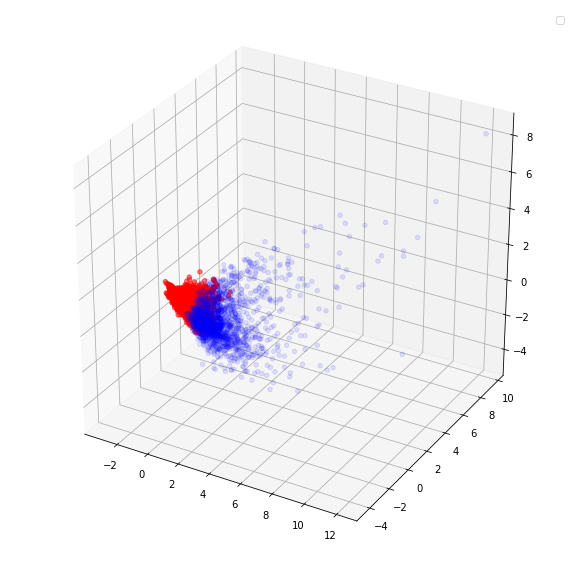

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(emb_pca_red[pred_red == 0][:,0], emb_pca_red[pred_red == 0][:,1],emb_pca_red[pred_red == 0][:,2], color='blue', alpha=0.1)
#ax.scatter(emb_pca_red[pred_red == 0][:,0], emb_pca_red[pred_red == 0][:,1],emb_pca_red[pred_red == 0][:,2], color='blue', alpha=0.1)
ax.scatter(emb_pca_red[pred_red >= 1][:,0], emb_pca_red[pred_red >= 1][:,1],emb_pca_red[pred_red >= 1][:,2], color='red', alpha=0.5)
#ax.scatter(emb_pca_red[pred_red >= 1][:,0], emb_pca_red[pred_red >= 1][:,1],emb_pca_red[pred_red >= 1][:,2], color='red', alpha=0.5)
ax.legend()
plt.show()

Using matplotlib backend: TkAgg


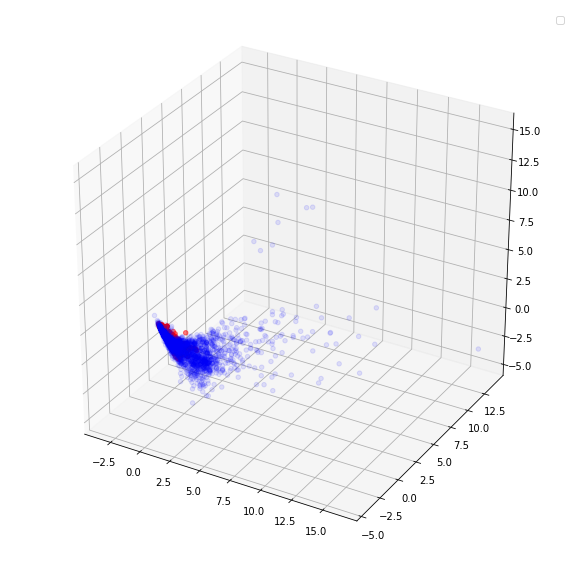

In [143]:
%matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(emb_pca_red[pred_red == 0][:,0], emb_pca_red[pred_red == 0][:,1],emb_pca_red[pred_red == 0][:,2], color='blue', alpha=0.1)
ax.scatter(emb_pca_red[ts_lbls_red == 0][:,0], emb_pca_red[ts_lbls_red == 0][:,1],emb_pca_red[ts_lbls_red == 0][:,2], color='blue', alpha=0.1)
# ax.scatter(emb_pca_red[pred_red >= 1][:,0], emb_pca_red[pred_red >= 1][:,1],emb_pca_red[pred_red >= 1][:,2], color='red', alpha=0.5)
ax.scatter(emb_pca_red[ts_lbls_red >= 1][:,0], emb_pca_red[ts_lbls_red >= 1][:,1],emb_pca_red[ts_lbls_red >= 1][:,2], color='red', alpha=0.5)
ax.legend()
plt.show()

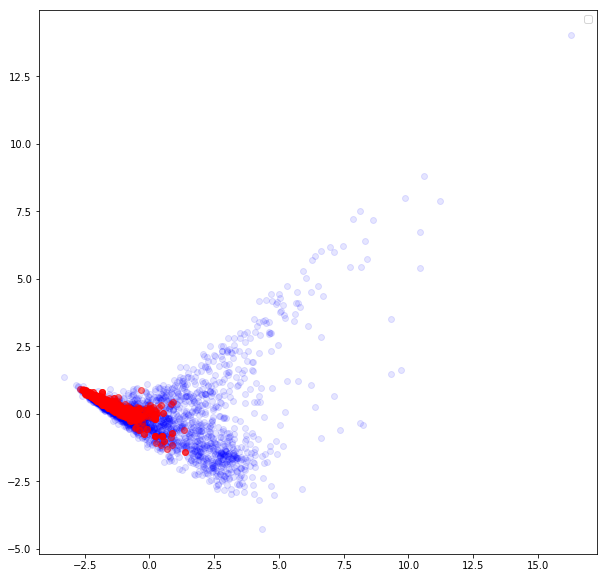

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
# ax.scatter(emb_pca_red[pred_red == 0][:,0], emb_pca_red[pred_red == 0][:,1],emb_pca_red[pred_red == 0][:,2], color='blue', alpha=0.1)
ax.scatter(emb_pca_red[ts_lbls_red == 0][:,0], emb_pca_red[ts_lbls_red == 0][:,1], color='blue', alpha=0.1)
# ax.scatter(emb_pca_red[pred_red >= 1][:,0], emb_pca_red[pred_red >= 1][:,1],emb_pca_red[pred_red >= 1][:,2], color='red', alpha=0.5)
ax.scatter(emb_pca_red[ts_lbls_red >= 1][:,0], emb_pca_red[ts_lbls_red >= 1][:,1], color='red', alpha=0.5)
ax.legend()
plt.show()

In [31]:
import time
t0 = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000, learning_rate=200)
# tsne_results = tsne.fit_transform((cls_embedding.cpu().numpy()-cls_embedding.mean().item()) / cls_embedding.std().item())
tsne_results = tsne.fit_transform(emb_pca)
print(time.time()-t0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.012s...
[t-SNE] Computed neighbors for 8000 samples in 0.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.141378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.463440
[t-SNE] Error after 2000 iterations: 1.032358
200.083522797


In [ ]:
data = dataset[0]
points = get_sample(cfg, data)
batch = points.batch

In [ ]:
with torch.no_grad():
    logits = classifier(points)
    
    pred = F.log_softmax(logits, dim=-1)
    pred_choice = pred.data.max(1)[1].int()
    
    idxs = data['obj_idxs']
    obj_embedding = classifier.node_embedding
    cls_embedding = classifier.embedding

In [ ]:
# class TestDataset(gDataset):
#     def __init__(self,
#                  subjects,
#                  root_dir,
#                  filename,
#                  gt_name=None,
#                  same_size=False,
#                  transform=None,
#                  return_edges=True,
#                  split_obj=True,
#                  ):
#         """
#         Args:
#             root_dir (string): root directory of the dataset.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.root_dir = root_dir
#         self.fn = filename
#         self.subjects = subjects
#         self.transform = transform
#         self.return_edges = return_edges
#         if split_obj:
#             self.remaining = [[] for _ in range(len(subjects))]
#         self.split_obj = split_obj
#         if gt_name is not None:
#             self.labels = []
#             for sub in subjects:
#                 label_sub_dir = os.path.join(self.root_dir.rsplit('/',1)[0], labels_dir ,'sub-%s' % sub)
#                 label_file = os.path.join(label_sub_dir, 'sub-%s_var-GIN_labels.npy' % (sub))
#                 self.labels.append(np.load(label_file))



#     def __len__(self):
#         if self.load_one_full_subj:
#             return len(self.full_subj[0])
#         return len(self.subjects)

#     def __getitem__(self, idx):

#         #print(self.subjects[idx])
#         #t0 = time.time()
#         item = self.getitem(idx)
#         #print('get item time: {}'.format(time.time()-t0))
#         return item

#     def getitem(self, idx):
#         sub = self.subjects[idx]
#         #t0 = time.time()
#         sub_dir = os.path.join(self.root_dir, 'sub-%s' % sub)
#         T_file = os.path.join(sub_dir, self.fn)
#         T = nib.streamlines.load(T_file, lazy_load=True)
#         #print('\tload lazy T %f' % (time.time()-t0))
#         #t0 = time.time()
#         gt = self.labels[idx]
#         #print('\tload gt %f' % (time.time()-t0))
#         if self.split_obj:
#             if len(self.remaining[idx]) == 0:
#                 self.remaining[idx] = set(np.arange(T.header['nb_streamlines']))
#             sample = {'points': np.array(list(self.remaining[idx]))}
#             if self.with_gt:
#                 sample['gt'] = gt[list(self.remaining[idx])]
#         else:
#             #sample = {'points': np.arange(T.header['nb_streamlines'])}
#             #if self.with_gt:
#             #sample['gt'] = gt
#             sample = {'points': np.arange(T.header['nb_streamlines']), 'gt': gt}
#         #print(sample['name'])

#         #t0 = time.time()
#         if self.transform:
#             sample = self.transform(sample)
#         #print('\ttime sampling %f' % (time.time()-t0))

#         if self.split_obj:
#             self.remaining[idx] -= set(sample['points'])
#             sample['obj_idxs'] = sample['points'].copy()
#             sample['obj_full_size'] = T.header['nb_streamlines']

#         sample['name'] = T_file.split('/')[-1].rsplit('.', 1)[0]
#         sample['dir'] = sub_dir

#         n = len(sample['points'])
#         if self.same_size:
#             streams, lengths = load_selected_streamlines_uniform_size(T_file,
#                                                     sample['points'].tolist())
#             if self.centering:
#                 streams_centered = streams.reshape(-1, lengths[0], 3)
#                 streams_centered -= streams_centered.mean(axis=1)[:,None,:]
#                 streams = streams_centered.reshape(-1,3) 
#         else:
#             streams, lengths = load_selected_streamlines(T_file,
#                                                     sample['points'].tolist())
            
#         sample['points'] = self.build_graph_sample(streams,
#                     lengths,
#                     torch.from_numpy(sample['gt']) if self.with_gt else None)
#         return sample

#     def center_sl_list(self, sl_list):
#         centers = np.array(map(functools.partial(np.mean, axis=0), sl_list))
#         return map(np.subtract, sl_list, centers)

#     def build_graph_sample(self, streams, lengths, gt=None):
#         lengths = torch.from_numpy(lengths).long()
#         batch_vec = torch.arange(len(lengths)).repeat_interleave(lengths)
#         batch_slices = torch.cat([torch.tensor([0]), lengths.cumsum(dim=0)])
#         slices = batch_slices[1:-1]
#         streams = torch.from_numpy(streams)
#         l = streams.shape[0]
#         graph_sample = gData(x=streams,
#                              lengths=lengths,
#                              bvec=batch_vec,
#                              pos=streams)

#         if self.return_edges:
#             e1 = set(np.arange(0,l-1)) - set(slices.numpy()-1)
#             e2 = set(np.arange(1,l)) - set(slices.numpy())
#             edges = torch.tensor([list(e1)+list(e2),list(e2)+list(e1)],
#                             dtype=torch.long)

#             graph_sample['edge_index'] = edges
#             num_edges = graph_sample.num_edges
#             edge_attr = torch.ones(num_edges,1)
#             graph_sample['edge_attr'] = edge_attr
#         if self.distance:
#             graph_sample = self.distance(graph_sample)

#         if gt is not None:
#             graph_sample['y'] = gt

#         return graph_sample


In [94]:
from models import DynamicEdgeConv, EdgeConv, MLP, Seq, Lin, global_max_pool, Dropout

In [95]:
class DECSeq(torch.nn.Module):
    def __init__(self, input_size, embedding_size, n_classes, dropout=True, k=5, aggr='max',pool_op='max'):
        super(DECSeq, self).__init__()
        self.conv1 = EdgeConv(MLP([2 * 3, 64, 64, 64]), aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        self.lin1 = MLP([128 + 64, 1024])
        if pool_op == 'max':
            self.pool = global_max_pool

        if dropout:
            self.mlp = Seq(
                MLP([1024, 512]), Dropout(0.5), MLP([512, 256]), Dropout(0.5),
                Lin(256, n_classes))
        else:
            self.mlp = Seq(
                MLP([1024, 512]), MLP([512, 256]),
                Lin(256, n_classes))
        self.node_embedding = None
        self.embedding = None

    def forward(self, data):
        pos, batch, eidx = data.pos, data.batch, data.edge_index
        x1 = self.conv1(pos, eidx)
        x2 = self.conv2(x1, batch)
        out = self.lin1(torch.cat([x1, x2], dim=1))
        self.node_embedding = out
        out = global_max_pool(out, batch)
        out = self.mlp[:2](out).data
        self.embedding = out
        out = self.mlp[2](out)
        return out

classifier = DECSeq(
    int(cfg['data_dim']),
    int(cfg['embedding_size']),
    2,
    dropout=cfg['dropout'],
    #fov=3,
    #k=int(cfg['k_dec']),
    k=5,
    aggr='max',
    #pool_op=global_max_pool)
    pool_op='max')

In [2]:
import tsnecuda
tsnecuda.test()